In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
from numba import jit
import classy
from tqdm import tqdm
plt.rcParams.update({'font.size': 28})

In [2]:
import sys
sys.path.append('/home/addis/PkBk/Library')
sys.path.append('/home/addis/PkBk/Scripts')
import get_field as gf
import compute_grid_info as cgi
import Pk 
import Pk1 

In [3]:
#field things!
path = '../../../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'

In [426]:
%%time
Nside=128
L=1000
rfft=False
order=2
obs_pos=(500,0,500) #
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)
#xi,x_norm,ki,k_mag,MAS,k_f,k_ny

CPU times: user 115 ms, sys: 51.6 ms, total: 166 ms
Wall time: 165 ms


In [5]:
%%time
iFFT=False
dtype=np.complex64
threads=4
verbose=True

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 5.96 µs


In [205]:
%%time
s=1/2 #units of 2*k_f
k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5]) + s*grid_info[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])
#In_bin,N_modes 

CPU times: user 325 ms, sys: 44.2 ms, total: 369 ms
Wall time: 366 ms


In [211]:
print(len(k_est))
print(k_est[10])

63
0.07225663103256524


In [7]:
%%time
realisation = str(10016)
field ='_LOS=Cen'
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + field+ '.npy') #load field

CPU times: user 0 ns, sys: 4.62 ms, total: 4.62 ms
Wall time: 2.64 ms


In [10]:
%%time
t= 0.5
l = 1
exorder = 2
Pk_ell = Pk.Pk(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)
Pk_ell1 = Pk1.Pk(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)

CPU times: user 46 s, sys: 8.94 s, total: 54.9 s
Wall time: 17.2 s


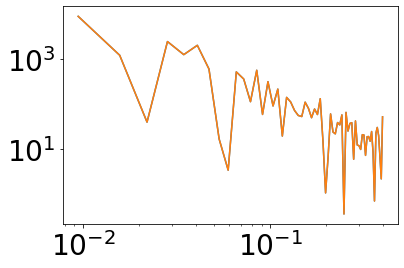

In [11]:
plt.loglog(k_est,np.abs(Pk_ell.pk))
plt.loglog(k_est,np.abs(Pk_ell1.pk))

In [207]:
#define empty dict to fill in...
pk = {
    'Cen' : {},#redshift space in centre
    '-500' : {},#z_obs
    '0':{},
    'PP' : {}, # PP with RSD
    'real': {}#real space
    } 

In [428]:
#pk['00'] ={}
#pk['000'] ={}
#pk['-1000'] ={}
#pk['250'] ={}
#pk['0_other'] ={}

In [429]:
def pk_realisations(field,pk_dict,ls,ts,exorder,obs_pos,N_min,N_max):#add path so choose fields as were
    """function to run to calculate bispectrum for different multiplles over realisations"""
    
    N_side=128
    L=1000
    rfft=False
    order=2
    #obs_pos=(500,500,z_obs)#
    grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)
    
    iFFT=False
    dtype=np.complex64
    threads=4
    verbose=True
    
    #s=1/2 #units of 2*k_f
    k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5]) + s*grid_info[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
    binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])
    #In_bin,N_modes 
    
    for t in ts:#which LOS
        for l in ls:  #which multipoles to calculate
            key_mono = 'l=%d'%(0)
            key ='l=%d'%(l) +',t=' + str(t)[-1]
            if key in pk_dict.keys():
                if len(pk_dict[key]) > N_max - N_min:#in case of error just delete
                    #pk_dict[key] = pk_dict[key][N_min:]
                    #pk_dict[key_mono] = pk_dict[key_mono][N_min:]
                    pk_dict.pop(key, None)
                    pk_dict.pop(key_mono, None)
                
            arr_pk = np.zeros((N_max-N_min,len(k_est)),dtype=np.complex64) #create empty arrays in dict to store bispectra
            arr_mono = np.zeros((N_max-N_min,len(k_est)),dtype=np.complex64)
            for i in tqdm(range(N_min,N_max)):
                realisation = str(10000 + i)
                                                            #
                field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + field+ '.npy') #load field
                j = Pk.Pk(field_tmp,L,N_side,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)
                arr_pk[i-N_min] = j.pk
                if l % 2 == 0:
                    arr_mono[i-N_min] = j.mono
  
                
            if key in pk_dict.keys(): # create array with extra zeros beyond which has already been computed
                pk_temp = np.zeros((N_max,len(k_est)),dtype=np.complex64) #create empty arrays in dict to store bispectra
                pk_temp[N_min:N_max] = arr_pk # set new results
                previous = 1*pk_dict[key] 
                pk_temp[:len(previous)] = previous # add prior results back
                pk_dict[key] = pk_temp # set new dict
                if l % 2 == 0:#if even
                    pk_temp = np.zeros((N_max,len(k_est)),dtype=np.complex64)
                    pk_temp[N_min:N_max] = arr_mono # set new results
                    previous = 1*pk_dict[key_mono] 
                    pk_temp[:len(previous)] = previous
                    pk_dict[key_mono] = pk_temp
            else:
                pk_dict[key] = arr_pk 
                pk_dict[key_mono] = arr_mono
                 
    return pk_dict

ls= [1]#
ts = [0]#

exorder = 1

field = '0_other'#str(obs_pos[-1]) #'000'#'Cen'# 'real'#'PP'#
field_add = '_LOS='+field
if field == 'real': #real has a different naming convention for no reason
    field_add = ''
    
pk[field] = pk_realisations(field_add,pk[field],ls,ts,exorder,obs_pos,0,100)


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


In [430]:
print(pk['-500'].keys())
print(obs_pos)

dict_keys(['l=1,t=0', 'l=0', 'l=2,t=0', 'l=1,t=5', 'l=2,t=5'])
(500, 0, 500)


In [431]:
def avg_err(Pk):#ok so adapt to nested dict structure...
    Pk_avg = {}
    Pk_err = {}
    Pk_std = {}
    for i in Pk.keys():#so this loops over each type - i.e. PP,Cen,real_space
        Pk_avg[i] = {}#create the nested dictionary to fill...
        Pk_err[i] = {}
        Pk_std[i] = {}
        for j in Pk[i].keys(): # loop over multipole keys - to get mean and std for each
            Pk_avg[i][j] = np.mean((Pk[i][j]),axis=0)
            Pk_err[i][j] = np.std(Pk[i][j],axis=0)/np.sqrt(len(Pk[i][j])) # standard error makes sense as we have independent realisations
            Pk_std[i][j] = np.std(Pk[i][j],axis=0)
    return Pk_avg,Pk_err,Pk_std

Pk_avg,Pk_err,Pk_std = avg_err(pk)

In [476]:
def get_chi(A_wa,PP_th,wa_th,data_mean,data_err):
    chi_arr = np.zeros((len(A_wa)))
    for i in range(len(A_wa)):
        chi_arr[i] = np.sum((data_mean - (PP_th+A_wa[i]*wa_th))**2 /data_err**2)
    return chi_arr

def get_likelihood(A_wa,PP_th,wa_th,data_mean,data_err):
    
    return np.exp(-get_chi(A_wa,PP_th,wa_th,data_mean,data_err)/2)

A_wa = np.linspace(-1,4,5000)

sigma =5
t=0
#so for quad...
#likelihood2 = get_likelihood(A_wa,pk_quad_dfog(k_est,sigma)[:9],pk_quad_dfog_wa(k_est,sigma,1000,0)[:9],Pk_avg['-500']['l=2,t=0'].real[:9],Pk_std['-500']['l=2,t=0'][:9])
likelihood1 = get_likelihood(A_wa,0,pk_dipo_dfog_wa(k_est,sigma,1000,0)[:9],-Pk_avg['0']['l=1,t=0'].imag[:9],Pk_std['-500']['l=1,t=0'][:9])

def likelihood_confidence(likelihood,conf_level):
    
    cum = np.cumsum(likelihood)
    
    norm = cum.max()
    index_high = np.argmax(cum/norm >= conf_level)
    index_low = np.argmax(cum/norm >= 1-conf_level)
    return index_low,index_high

In [481]:
key = '-1000'
like_test = get_likelihood(A_wa,0,pk_dipo_dfog_wa(k_est,sigma,1000,0)[:9],-Pk_avg[key]['l=1,t=0'].imag[:9],Pk_std[key]['l=1,t=0'][:9])


In [482]:
print(likelihood_confidence(likelihood1,0.60))

(1874, 2064)


0.0702140428085618 -0.2528505701140228 0.3942788557711543


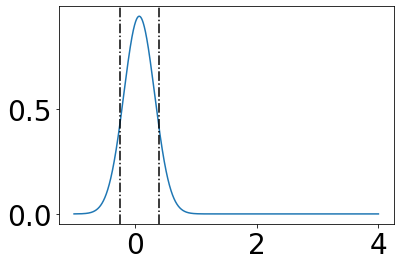

In [483]:
#print(likelihood)
likelihood = like_test
low,high = likelihood_confidence(likelihood,0.90)
plt.plot(A_wa,likelihood)
plt.axvline(x = A_wa[low], linestyle='-.', color = 'black')
plt.axvline(x = A_wa[high], linestyle='-.', color = 'black')
print(A_wa[np.argmax(likelihood)],A_wa[low],A_wa[high])

In [286]:
print(pk['-500']['l=1,t=0'].shape)

(200, 63)


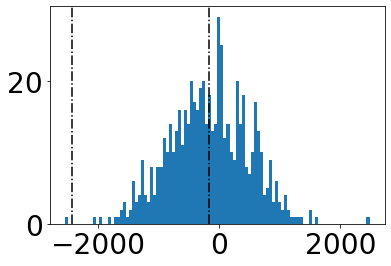

In [310]:
plt.hist(pk['-500']['l=1,t=0'][:,4].imag,bins=100)
plt.axvline(x = -pk_dipo_dfog_wa(k_est,sigma,1010,0)[1], linestyle='-.', color = 'black')
plt.axvline(x = Pk_avg['-500']['l=1,t=0'].imag[4], linestyle='-.', color = 'black')

<ipython-input-324-3b2067f9a652>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(ks,Pl0_pp,'-',color='blue')


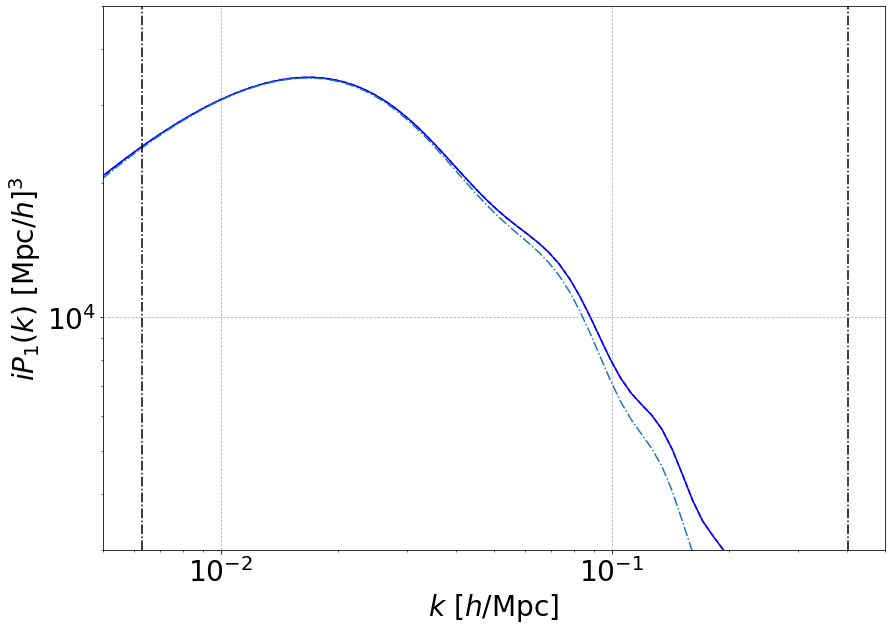

In [324]:
#monopole!!!
plt.figure(figsize=(14,10))

#plt.errorbar(k_est,np.abs(Pk_avg['0']['l=0'].real),yerr=Pk_err['0']['l=0'],fmt ='o',color='blue')
plt.errorbar(k_est,(Pk_avg['-500']['l=0'].real),yerr=Pk_err['-500']['l=0'],fmt ='o',color='orange')

plt.loglog(ks,Pl0_pp,'-',color='blue')
plt.loglog(ks,Pl0_pp+Pk_l0_wa,'--',color='blue')
plt.plot(ks,pk_mono_dfog(ks,10)+pk_mono_dfog_wa(ks,10,1010,0),'-.')

plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(5e-3,0.5e0)
plt.ylim(3e+3,5e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)
plt.savefig("P_0_pp_comp.png",bbox_inches='tight')#

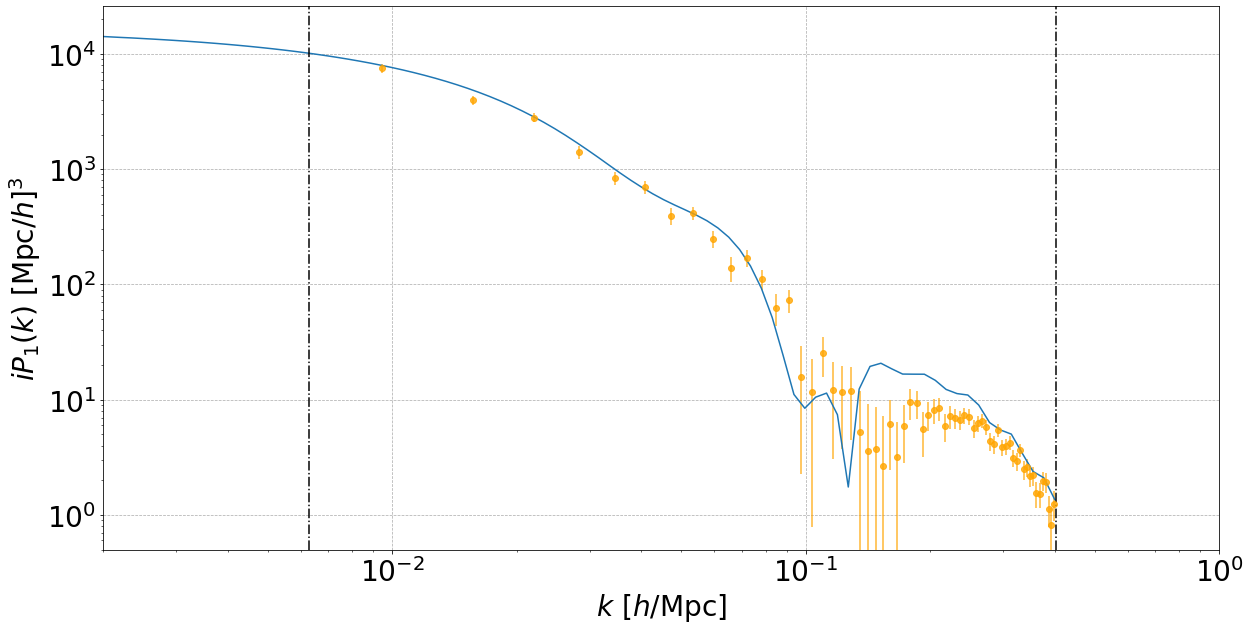

In [444]:
#dipole!!!
plt.figure(figsize=(20,10))

key1 = 'Cen'

#plt.errorbar(k_est,np.abs(Pk_avg['0']['l=1,t=0']),yerr=Pk_err['0']['l=1,t=0'],fmt ='o',linestyle='none',alpha=0.8)
#plt.errorbar(k_est,np.abs(Pk_avg['0']['l=1,t=5']),yerr=Pk_err['0']['l=1,t=5'],fmt ='o',linestyle='none',alpha=0.8)

plt.errorbar(k_est,np.abs(Pk_avg[key1]['l=1,t=0']),yerr=Pk_err[key1]['l=1,t=0'],fmt ='o',linestyle='none',color='orange',alpha=0.8)
#plt.errorbar(k_est,np.abs(Pk_avg['-500']['l=1,t=5']),yerr=Pk_err['-500']['l=1,t=5'],fmt ='o',linestyle='none',color='red',alpha=0.8)

for i in range(100):
    1#plt.plot(k_est,-(pk['0']['l=1,t=0'][i].imag),'.',alpha=0.6,color='grey')


plt.plot(ks,np.abs(dip_dfog(ks,5,500,0)))
#plt.plot(ks,np.abs(dip_dfog_fake(ks,5,560,t)))
#plt.plot(ks,Pk_l1_wa) 

plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
plt.xlim(2e-3,1e0)
#plt.ylim(-1e+4,1e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.yscale('log')
plt.xscale('log')
plt.grid(ls='--',lw=0.75)
#plt.savefig("P_0_pp_comp.png",bbox_inches='tight')#

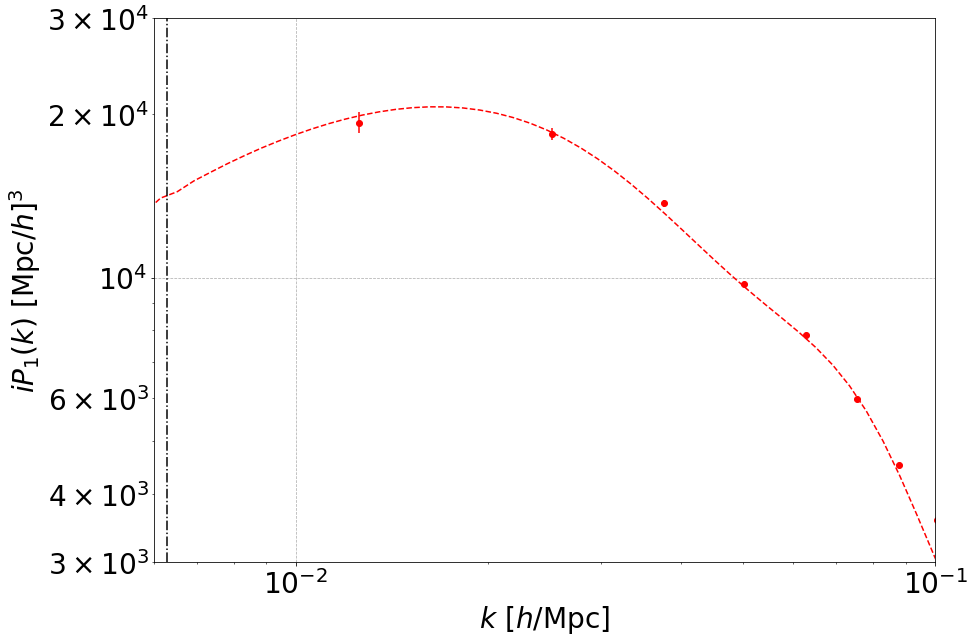

In [188]:
#quadrupole
plt.figure(figsize=(14,10))

#plt.errorbar(k_est,np.abs(Pk_avg['0']['l=2,t=0'].real),yerr=Pk_err['0']['l=2,t=0'],fmt ='o',color='green')
plt.errorbar(k_est,(Pk_avg['-500']['l=2,t=5'].real),yerr=Pk_err['-500']['l=2,t=5'],fmt ='o',color='red')
#plt.plot(ks,np.abs(full_dfog(ks,5.22,0)))


#plt.plot(ks,np.abs(pk_dfog(ks,5)),'--',color='black')
#plt.plot(ks,np.abs(wa_dfog(ks,5,560,0)),'--',color='green')
plt.plot(ks,np.abs(wa_dfog(ks,5,1000,0.5)),'--',color='red')

#plt.loglog(ks,Pl2_pp,'--',color='black')
for i in range(100):
    1#plt.loglog(k_est,(np.abs(pk_500['l=2,t=5'][i].real)),'.',alpha=0.2,color='blue')
    1#plt.loglog(k_est,(np.abs(pk_500['l=2,t=0'][i].real)),'.',alpha=0.2,color='red')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(6e-3,0.1e0)
plt.ylim(3e+3,3e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)
plt.savefig("P_0_pp_comp.png",bbox_inches='tight')

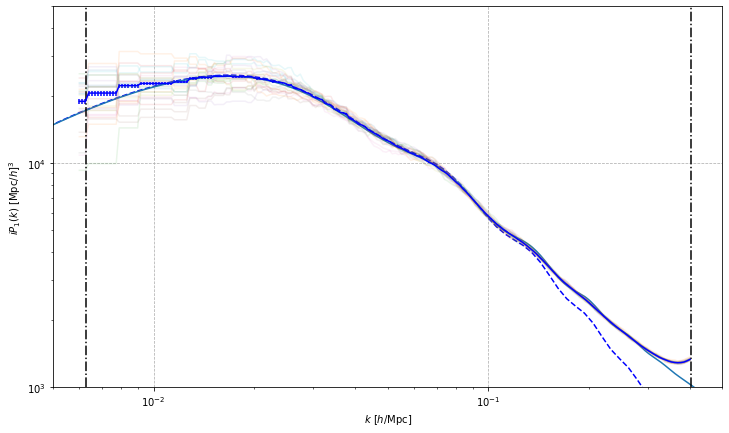

In [464]:
#real space
plt.figure(figsize=(12,7))


plt.errorbar(k_est,np.abs(Pk_avr['real']['l=0']),yerr=Pk_err['real']['l=0'],color='blue')
plt.plot(ks[10:],Pks[10:],'--',color='blue')
plt.plot(k,Pnonlin)
#plt.loglog(k_py,Pk0)
#plt.errorbar(k_est,np.abs(Pk_avg_real['l=2,t=0'].real),yerr=Pk_err_real['l=2,t=0'],color='red')
#plt.plot(ks,Pl2_pp+Pk_l2_wa,'--',color='red')


for i in range(25):
    plt.loglog(k_est,(np.abs(pk_real['l=0'][i].real)),alpha=0.1)


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(5e-3,0.5e0)
plt.ylim(1e+3,5e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)

In [82]:
%%time
import sys
sys.path.append('/home/addis/Pylians3/library/build/lib.linux-x86_64-3.8')
import Pk_library as PKL
BoxSize = 1000.0 #Mpc/h
axis    = 0
MAS     = 'CIC'
threads = 4
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '.npy')
Pk_py = PKL.Pk(np.array(field_tmp,dtype=np.float32), L, axis, MAS, threads, True)


Computing power spectrum of the field...
Time to complete loop = 0.12
Time taken = 0.21 seconds
CPU times: user 5.57 s, sys: 179 ms, total: 5.75 s
Wall time: 281 ms


In [83]:
k_py   = Pk_py.k3D
Pk0     = Pk_py.Pk[:,0] #monopole
Pk2     = Pk_py.Pk[:,1] #quadrupole
Pk4     = Pk_py.Pk[:,2] #hexadecapole

NameError: name 'Pk_avg_real' is not defined

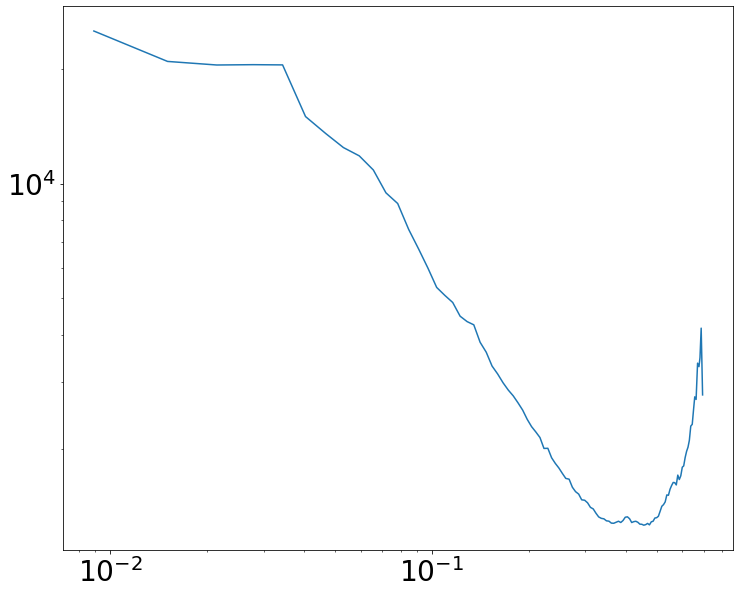

In [84]:
#pylians comparison
plt.figure(figsize=(12,10))
plt.loglog(k_py,Pk0)
plt.loglog(k_est,np.abs(Pk_avg_real['l=0'].real))

In [ ]:
#%%time
t=0.5
import cProfile
cProfile.run('Pk.Pk(field_tmp,L,Nside,l,k,grid_info,binning_info, t,iFFT,dtype,threads,rfft,verbose)')

In [ ]:
#this just changes things from mathematica form to python
from sympy.parsing.mathematica import mathematica  
from sympy import var

In [15]:
with open('mathematica_output.txt') as file:
    string1 = file.read()
    string1 = string1.replace('\n','').replace('  ','')#.replace('Sqrt[pi]','(np.pi)**(1/2)')
#print(string1.replace(". ", "").replace("\n", "").replace("\\", "").replace("x", "d").replace("kd^2", "(k*d**2)"))#.replace("k", "k[i]"))

#change multiplication and 
python_mathematica = mathematica(string1)
ppp = str(python_mathematica).replace('*I*','*1j*').replace('sqrt(','np.sqrt(').replace('pi','np.pi').replace('e**(','np.exp(').replace('erfunccc','scipy.special.erf((sigma*ks)/np.sqrt(2))').replace('erfunc','scipy.special.erf(sigma*ks)').replace('e**(','np.exp(')
print(ppp)

FileNotFoundError: [Errno 2] No such file or directory: 'mathematica_output.txt'

In [17]:
from classy import Class
z= 0
#Start by specifying the cosmology - fiducial quijote...
Omega_b = 0.049#0.05
Omega_m = 0.3175
Omega_l = 0.682
Omega_cdm = Omega_m - Omega_b
h = 0.6711#0.7 #H0/100
A_s = 2.1e-9
n_s = 0.9624
a = 1/(1+z)
H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc

params = {   'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}
#Initialize the cosmology and compute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
#z already specififed

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [328]:
#create x_c to integrate over - lets say it's a 1000 MPc/h (128x128x128) grid situated at (x,y,z)
Nside_theory= 128
conf_space = np.linspace(0,1000,Nside_theory)
x_unorm , y_unorm , z_unorm = np.meshgrid(conf_space-obs_pos[0], conf_space-obs_pos[1], conf_space-obs_pos[2],indexing='ij') 
conf_norm = np.sqrt(x_unorm**2 + y_unorm**2 + z_unorm**2) # make a unit vector - normalise
ds = np.where(conf_norm==0,1,conf_norm)
print(1/np.mean(1/ds))

423.4657347814862


In [19]:
# Lambda CDM
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy import interpolate
LCDM = Class()
LCDM.compute()
print(LCDM.get_current_derived_parameters)
baLCDM = LCDM.get_background()
print(baLCDM.keys())
f_cl = baLCDM['gr.fac. f']
z_cl = baLCDM['z']
H_cl = baLCDM['H [1/Mpc]'];H = interp1d(z_cl,H_cl*(1/(1+z_cl))/h,kind='cubic') # now in h/Mpc!
xi_cl = baLCDM['comov. dist.']; comoving_dist = interp1d(z_cl,xi_cl*h,kind='cubic') # just use class background as quick
f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)

<built-in method get_current_derived_parameters of classy.Class object at 0x557b8c56c2b0>
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [123]:
#%%time
z= 0.0
print(z)
#ok so set a comoving distance of observation
d = comoving_dist(z)
if d == 0:
    d=np.sqrt(250**2 + 250**2 + 250**2)
print(d)
#set z ...
def get_class_powerspectrum(kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
    
    return np.array([cosmo.pk_lin(ki, zz) for ki in kk*h])*h**3

def get_pkinfo_z(k,z):
    Plin = get_class_powerspectrum(k,z)
    Pk = interpolate.interp1d(k,Plin)#Plin
    Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))#(k[1:]+k[:-1])/2,np.diff(Plin)/np.diff(k)
    Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
    return Pk,Pk_d,Pk_dd

#so set parameters...
Pk_,Pk_d,Pk_dd = get_pkinfo_z(k,z)


ks = np.geomspace(1e-3,4e-1,100)
f = f_intp(z)

Pks = Pk_(ks)
Pkd= Pk_d(ks)
Pkdd= Pk_dd(ks)

d=1000
b1 = 1
s=0
t=0

0.0
433.0127018922193


In [124]:
Pk_l0_wa = f*(Pks*(7*b1*(-25*s - t*(12*t - 12) + 4) + f*(175*s - t*(36*t - 36) - 68)) + ks*(Pkd*(-35*b1*(5*s + t*(4*t - 4)) + f*(175*s - t*(60*t - 60) - 48)) - 2*Pkdd*ks*(7*b1*(t*(2*t - 2) + 1) + f*(t*(6*t - 6) - 5))))/(105*d**2*ks**2)
Pk_l1_wa = -4*f*(3*Pks+ Pkd*ks)*(7*b1 + 3*f)*(2*t - 1)/(35*d*ks)
Pk_l2_wa = 2*f*(-Pks*(2*b1*(70*s + t*(66*t - 66) + 5) + f*(-35*s + t*(108*t - 108) + 40)) + ks*(Pkd*(b1*(70*s + t*(44*t - 44) - 6) + f*(35*s - t*(12*t - 12) - 6)) + Pkdd*ks*(11*b1 + 3*f)*(t*(2*t - 2) + 1)))/(21*d**2*ks**2)


Pl0_pp = b1**2 *Pks+ (2*b1*f*Pks)/3 + (f**2 *Pks)/5
Pl2_pp = (4*b1*f*Pks)/3 + (4*f**2 *Pks)/7

In [125]:
#these are some multipoles without inverse distance terms
Pk_l0_wa1 = 2*f*(Pks*(-21*b1*(t*(2*t - 2) + 1) - 18*f*t*(t - 1) + f) + ks*(Pkd*(-35*b1*(t*(2*t - 2) + 1) + f*(-t*(30*t - 30) + 11)) + Pkdd*ks*(-7*b1*(t*(2*t - 2) + 1) + f*(-t*(6*t - 6) + 5))))/(105*d**2*ks**2)
Pk_l2_wa1 = 2*f*(-2*Pks*(33*b1*(t*(2*t - 2) + 1) + f*(t*(54*t - 54) + 13)) + ks*(2*Pkd*(22*b1*t*(t - 1) + 11*b1 - 6*f*t*(t - 1) + 4*f) + Pkdd*ks*(11*b1 + 3*f)*(t*(2*t - 2) + 1)))/(21*d**2*ks**2)


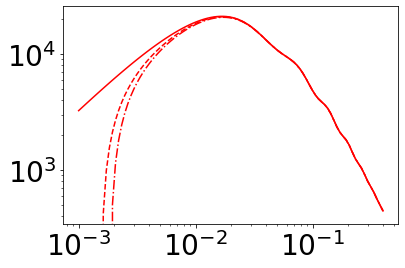

In [126]:
#plt.loglog(ks,Pl0_pp,color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa,'--',color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa1,'-.',color='blue')
plt.loglog(ks,Pl2_pp,color='red')
plt.loglog(ks,Pl2_pp+Pk_l2_wa,'--',color='red')
plt.loglog(ks,Pl2_pp+Pk_l2_wa1,'-.',color='red')
#plt.loglog(ks,Pk_l1_wa)

In [127]:
import scipy 

In [128]:
#all quadrupole
#PP with dfog
def pk_dfog(ks,sigma):
    Pks= Pk_(ks)
    return 5*Pks*np.exp(-ks**2*sigma**2)*(-np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(8*b1**2*ks**6*sigma**6 + 4*b1*ks**4*sigma**4*(-3*b1 + 2*f) - 45*f**2 + 6*f*ks**2*sigma**2*(-6*b1 + f)) - 90*f**2*ks*sigma - 24*f*ks**3*sigma**3*(3*b1 + 2*f) - ks**5*sigma**5*(24*b1**2 + 32*b1*f + 16*f**2))/(32*ks**7*sigma**7)

#include all terms!!
def full_dfog_inv(ks,sigma,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return -5*np.exp(-ks**2*sigma**2)*(-8*Pks*(-8*b1**2*ks**9*sigma**7*(6*d**2 + sigma**2*(4*ks**2*sigma**2 - t**2*(16*ks**2*sigma**2 + 24) + t*(16*ks**2*sigma**2 + 24) + 15)) + 4*b1*f*ks**3*sigma**3*(-16*ks**8*sigma**8 - 16*ks**6*sigma**4*(d**2 + sigma**2*(7 - 5*s)) - 4*ks**4*(9*d**2*sigma**2 + sigma**4*(73 - 70*s)) + 15*ks**2*sigma**2*(24*s - 35) + t**2*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) - t*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) - 450) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**8*sigma**6*(d**2*(-4*ks**2*sigma**2 + 6) + 3*sigma**2*(-2*ks**2*sigma**2 - 8*t**2 + 8*t + 5)) - 2*b1*f*ks**2*sigma**2*(8*d**2*ks**6*sigma**4 + ks**4*(-36*d**2*sigma**2 + sigma**4*(40*s - 22)) + 45*ks**2*sigma**2*(8*s - 5) - t**2*(792*ks**2*sigma**2 - 5400) + t*(792*ks**2*sigma**2 - 5400) - 450) + f**2*(-2*ks**6*(6*d**2*sigma**4 + sigma**6*(100*s**2 - 120*s + 39)) + 9*ks**4*(10*d**2*sigma**2 + sigma**4*(100*s**2 - 160*s + 81)) - 2385*ks**2*sigma**2 - t**2*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + t*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + 12285)) - 2*f**2*ks*sigma*(16*ks**10*sigma**10 + 16*ks**8*sigma**6*(d**2 + sigma**2*(11 - 10*s)) + ks**6*(48*d**2*sigma**4 + sigma**6*(400*s**2 - 720*s + 708)) + 15*ks**4*(6*d**2*sigma**2 + sigma**4*(60*s**2 - 96*s + 161)) + 5805*ks**2*sigma**2 - t**2*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + t*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + 12285)) + ks*(Pkd*(8*b1**2*ks**5*sigma**5*(-24*ks**4*sigma**4 - 138*ks**2*sigma**2 + t**2*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - t*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - 45) + 8*b1*f*ks**3*sigma**3*(-96*ks**6*sigma**6 + 40*ks**4*sigma**4*(2*s - 9) + 6*ks**2*sigma**2*(120*s - 191) + t**2*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - t*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(12*b1**2*ks**4*sigma**4*(16*ks**6*sigma**6 - 20*ks**4*sigma**4 + 36*ks**2*sigma**2 + t**2*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) - t*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) + 15) - 4*b1*f*ks**2*sigma**2*(16*ks**6*sigma**6*(10*s - 3) + 4*ks**4*sigma**4*(51 - 100*s) + 36*ks**2*sigma**2*(20*s - 11) + t**2*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - t*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - 1125) + f**2*(80*ks**6*sigma**6*(4*s - 3) - 36*ks**4*sigma**4*(40*s - 59) - 10620*ks**2*sigma**2 - t**2*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + t*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + 36855)) + 2*f**2*ks*sigma*(-192*ks**8*sigma**8 + 128*ks**6*sigma**6*(5*s - 9) + 24*ks**4*sigma**4*(60*s - 203) - 13950*ks**2*sigma**2 + t**2*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - t*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - 36855)) + Pkdd*ks*(8*b1**2*ks**5*sigma**5*(4*ks**4*sigma**4 + 12*ks**2*sigma**2 + t**2*(24*ks**2*sigma**2 - 540) + t*(-24*ks**2*sigma**2 + 540) + 45) - 8*b1*f*ks**3*sigma**3*(-28*ks**4*sigma**4 - 96*ks**2*sigma**2 + t**2*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - t*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**4*sigma**4*(8*ks**6*sigma**6 - 4*ks**4*sigma**4 + 18*ks**2*sigma**2 + t**2*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - t*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - 45) - 4*b1*f*ks**2*sigma**2*(8*ks**6*sigma**6 + 4*ks**4*sigma**4 - 54*ks**2*sigma**2 - t**2*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + t*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + 225) + f**2*(56*ks**6*sigma**6 - 492*ks**4*sigma**4 + 1950*ks**2*sigma**2 + t**2*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - t*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - 4095)) + 2*f**2*ks*sigma*(64*ks**6*sigma**6 + 284*ks**4*sigma**4 + 780*ks**2*sigma**2 - t**2*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + t*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + 4095))))/(512*d**2*ks**11*sigma**9)

#include no inverse dist stuff
def wa_dfog(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return -5*np.exp(-ks**2*sigma**2)*(-8*Pks*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**8*sigma**6*(d**2*(-4*ks**2*sigma**2 + 6) + 3*sigma**2*(-2*ks**2*sigma**2 - 8*t**2 + 8*t + 5)) - 2*b1*f*ks**2*sigma**2*(8*d**2*ks**6*sigma**4 - 6*ks**4*(6*d**2*sigma**2 + sigma**4) - 81*ks**2*sigma**2 - t**2*(792*ks**2*sigma**2 - 5400) + t*(792*ks**2*sigma**2 - 5400) - 450) + f**2*(-2*ks**6*(6*d**2*sigma**4 + 7*sigma**6) + 9*ks**4*(10*d**2*sigma**2 + 33*sigma**4) - 2385*ks**2*sigma**2 - t**2*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + t*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + 12285)) - 2*ks*sigma*(4*b1**2*ks**8*sigma**6*(6*d**2 + sigma**2*(4*ks**2*sigma**2 - t**2*(16*ks**2*sigma**2 + 24) + t*(16*ks**2*sigma**2 + 24) + 15)) + 2*b1*f*ks**2*sigma**2*(16*ks**8*sigma**8 + 16*ks**6*sigma**4*(d**2 + 5*sigma**2) + 36*ks**4*sigma**2*(d**2 + 5*sigma**2) + 381*ks**2*sigma**2 - t**2*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) + t*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) + 450) + f**2*(16*ks**10*sigma**10 + 16*ks**8*sigma**6*(d**2 + 7*sigma**2) + ks**6*(48*d**2*sigma**4 + 484*sigma**6) + 3*ks**4*(30*d**2*sigma**2 + 661*sigma**4) + 5805*ks**2*sigma**2 - t**2*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + t*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + 12285))) + ks*(Pkd*(8*b1**2*ks**5*sigma**5*(-24*ks**4*sigma**4 - 138*ks**2*sigma**2 + t**2*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - t*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - 45) + 8*b1*f*ks**3*sigma**3*(-96*ks**6*sigma**6 - 328*ks**4*sigma**4 - 858*ks**2*sigma**2 + t**2*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - t*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(12*b1**2*ks**4*sigma**4*(16*ks**6*sigma**6 - 20*ks**4*sigma**4 + 36*ks**2*sigma**2 + t**2*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) - t*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) + 15) - 4*b1*f*ks**2*sigma**2*(16*ks**6*sigma**6 + 44*ks**4*sigma**4 - 108*ks**2*sigma**2 + t**2*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - t*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - 1125) + f**2*(-112*ks**6*sigma**6 + 1548*ks**4*sigma**4 - 10620*ks**2*sigma**2 - t**2*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + t*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + 36855)) + 2*f**2*ks*sigma*(-192*ks**8*sigma**8 - 896*ks**6*sigma**6 - 4296*ks**4*sigma**4 - 13950*ks**2*sigma**2 + t**2*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - t*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - 36855)) + Pkdd*ks*(8*b1**2*ks**5*sigma**5*(4*ks**4*sigma**4 + 12*ks**2*sigma**2 + t**2*(24*ks**2*sigma**2 - 540) + t*(-24*ks**2*sigma**2 + 540) + 45) - 8*b1*f*ks**3*sigma**3*(-28*ks**4*sigma**4 - 96*ks**2*sigma**2 + t**2*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - t*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**4*sigma**4*(8*ks**6*sigma**6 - 4*ks**4*sigma**4 + 18*ks**2*sigma**2 + t**2*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - t*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - 45) - 4*b1*f*ks**2*sigma**2*(8*ks**6*sigma**6 + 4*ks**4*sigma**4 - 54*ks**2*sigma**2 - t**2*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + t*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + 225) + f**2*(56*ks**6*sigma**6 - 492*ks**4*sigma**4 + 1950*ks**2*sigma**2 + t**2*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - t*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - 4095)) + 2*f**2*ks*sigma*(64*ks**6*sigma**6 + 284*ks**4*sigma**4 + 780*ks**2*sigma**2 - t**2*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + t*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + 4095))))/(512*d**2*ks**11*sigma**9)

#fake fog with no wide ange mixing
def wa_dfog_fake(ks,sigma,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return 5*np.exp(-ks**2*sigma**2)*(Pks*(-24*b1**2*d**2*ks**9*sigma**7 - 8*b1*f*ks**3*sigma**3*(4*d**2*ks**6*sigma**4 + ks**4*(9*d**2*sigma**2 - 28*sigma**4) - 111*ks**2*sigma**2 - t**2*(56*ks**4*sigma**4 + 222*ks**2*sigma**2 + 720) + t*(56*ks**4*sigma**4 + 222*ks**2*sigma**2 + 720) - 360) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*d**2*ks**8*sigma**6*(-2*ks**2*sigma**2 + 3) - 4*b1*f*ks**2*sigma**2*(2*d**2*ks**6*sigma**4 - 9*ks**4*sigma**2*(d**2 - 2*sigma**2) - 129*ks**2*sigma**2 + t**2*(36*ks**4*sigma**4 - 258*ks**2*sigma**2 + 720) - t*(36*ks**4*sigma**4 - 258*ks**2*sigma**2 + 720) + 360) + f**2*(ks**6*(-6*d**2*sigma**4 + 56*sigma**6) + ks**4*(45*d**2*sigma**2 - 804*sigma**4) + 5580*ks**2*sigma**2 + t**2*(144*ks**6*sigma**6 - 2232*ks**4*sigma**4 + 16200*ks**2*sigma**2 - 45360) - t*(144*ks**6*sigma**6 - 2232*ks**4*sigma**4 + 16200*ks**2*sigma**2 - 45360) - 15120)) + 2*f**2*ks*sigma*(-8*d**2*ks**8*sigma**6 - 24*ks**6*sigma**4*(d**2 - 6*sigma**2) - 9*ks**4*(5*d**2*sigma**2 - 124*sigma**4) + 4500*ks**2*sigma**2 + t**2*(480*ks**6*sigma**6 + 3528*ks**4*sigma**4 + 14040*ks**2*sigma**2 + 45360) - t*(480*ks**6*sigma**6 + 3528*ks**4*sigma**4 + 14040*ks**2*sigma**2 + 45360) + 15120)) + f*ks*(-2*Pkd*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(-2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(14*ks**4*sigma**4 - 93*ks**2*sigma**2 + 225) + f*(16*ks**6*sigma**6 - 186*ks**4*sigma**4 + 1125*ks**2*sigma**2 + t**2*(48*ks**6*sigma**6 - 576*ks**4*sigma**4 + 3510*ks**2*sigma**2 - 8505) + t*(-48*ks**6*sigma**6 + 576*ks**4*sigma**4 - 3510*ks**2*sigma**2 + 8505) - 2835)) + 6*ks*sigma*(2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(4*ks**4*sigma**4 + 19*ks**2*sigma**2 + 75) + f*(8*ks**6*sigma**6 + 64*ks**4*sigma**4 + 255*ks**2*sigma**2 + t**2*(16*ks**6*sigma**6 + 168*ks**4*sigma**4 + 720*ks**2*sigma**2 + 2835) - t*(16*ks**6*sigma**6 + 168*ks**4*sigma**4 + 720*ks**2*sigma**2 + 2835) + 945))) + Pkdd*ks*(4*b1*ks**3*sigma**3*(2*t**2 - 2*t + 1)*(2*ks**4*sigma**4 + 3*ks**2*sigma**2 + 90) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(4*ks**6*sigma**6 - 16*ks**4*sigma**4 + 57*ks**2*sigma**2 - 90) + f*(4*ks**6*sigma**6 - 48*ks**4*sigma**4 + 285*ks**2*sigma**2 + t**2*(24*ks**6*sigma**6 - 216*ks**4*sigma**4 + 990*ks**2*sigma**2 - 1890) - t*(24*ks**6*sigma**6 - 216*ks**4*sigma**4 + 990*ks**2*sigma**2 - 1890) - 630)) + 2*f*ks*sigma*(26*ks**4*sigma**4 + 135*ks**2*sigma**2 + t**2*(60*ks**4*sigma**4 + 270*ks**2*sigma**2 + 1890) - t*(60*ks**4*sigma**4 + 270*ks**2*sigma**2 + 1890) + 630))))/(32*d**2*ks**11*sigma**9)



#not sure what these two are...
def wainv_dfog(ks,sigma):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -5*f*(5*s - 2)*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(4*Pks*(9*b1 + 9*f + ks**2*sigma**2*(b1 - f)) + Pkd*ks*(-4*b1*ks**4*sigma**4 - 18*b1 - 9*f + ks**2*sigma**2*(10*b1 + 2*f))) + 2*np.exp(-ks**2*sigma**2)*ks*sigma*(-4*Pks*(9*b1 + 9*f + ks**4*sigma**4*(2*b1 + 2*f) + ks**2*sigma**2*(7*b1 + 5*f)) + Pkd*ks*(18*b1 + 9*f + ks**2*sigma**2*(2*b1 + 4*f))))/(16*d**2*ks**7*sigma**5)

def inv_dfog(ks,sigma):
    Pks= Pk_(ks)
    return 5*Pks*f**2*(2 - 5*s)**2*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(-2*ks**2*sigma**2 + 9) - 2*np.exp(-ks**2*sigma**2)*ks*sigma*(4*ks**2*sigma**2 + 9))/(16*d**2*ks**7*sigma**5)


In [129]:
#dipole stuff 
#include all terms!!
def dip_dfog(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return 3*1j*np.exp(-ks**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(Pkd*ks*(-8*b1**2*ks**6*sigma**6 + 4*b1*ks**4*sigma**4*(3*b1 - 2*f) + 45*f**2 - 6*f*ks**2*sigma**2*(-6*b1 + f)) - 4*Pks*(4*b1**2*ks**6*sigma**6 + 45*f**2 - 3*f*ks**2*sigma**2*(-6*b1 + f))) + 2*ks*sigma*(-Pkd*ks*(45*f**2 + 12*f*ks**2*sigma**2*(3*b1 + 2*f) + ks**4*sigma**4*(12*b1**2 + 16*b1*f + 8*f**2)) + 4*Pks*(45*f**2 + 2*f*ks**4*sigma**4*(6*b1 + 5*f) + 9*f*ks**2*sigma**2*(2*b1 + 3*f) + 4*ks**6*sigma**6*(b1 + f)**2)))/(32*d*ks**8*sigma**7)

#fake fog
def dip_dfog_fake(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -3*1j*np.exp(-ks**2*sigma**2)*f*(2*t - 1)*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(Pkd*ks*(-4*b1*ks**4*sigma**4 + 15*f + ks**2*sigma**2*(6*b1 - 6*f)) + 12*Pks*(-5*f + ks**2*sigma**2*(-b1 + f))) + 2*ks*sigma*(-Pkd*ks*(15*f + ks**2*sigma**2*(6*b1 + 4*f)) + 4*Pks*(15*f + ks**4*sigma**4*(2*b1 + 2*f) + ks**2*sigma**2*(3*b1 + 7*f))))/(8*d*ks**8*sigma**7)




(32,)


array([-2.76963195e+02, -6.06022421e+01, -1.15253253e+00,  2.50189178e+00,
       -2.88834010e+00, -3.07321708e+00,  1.06202305e+00,  2.71265557e+00,
        1.23290621e+00, -5.87220200e-01, -6.52642266e-01,  4.08136172e-01,
        8.47739349e-01,  4.19709982e-01, -1.25918302e-01, -1.97238162e-01,
        1.13712292e-01,  2.65531239e-01,  1.76019595e-01,  1.41028824e-03,
       -4.58668075e-02,  2.34290402e-02,  8.87870306e-02,  7.25447035e-02,
        2.23108573e-02, -4.03177068e-03,  1.04733593e-02,  2.97322477e-02,
        3.08368818e-02,  1.66849197e-02,  6.79680806e-03,  7.08463759e-03])

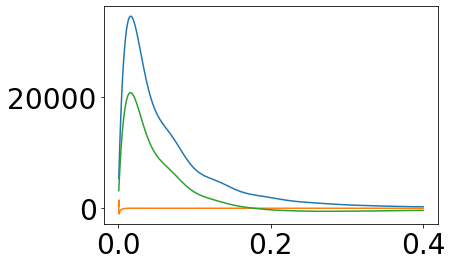

In [163]:
#PP functions with Dfog
def pk_mono_dfog(kk,sigma):
    Pks = Pk_(kk)
    return Pks*(np.sqrt(np.pi)*scipy.special.erf(sigma*f*kk)*(4*b1*f*kk**2*sigma**2*(b1*f*kk**2*sigma**2 + 1) + 3) + 2*np.exp(-f**2*kk**2*sigma**2)*f*kk*sigma*(-2*f*kk**2*sigma**2*(2*b1 + f) - 3))/(8*f**3*kk**5*sigma**5)

def pk_quad_dfog(kk,sigma):
    
    Pks = Pk_(kk)
    return  -5*Pks*np.exp(-f**2*kk**2*sigma**2)*(np.sqrt(np.pi)*np.exp(f**2*kk**2*sigma**2)*scipy.special.erf(sigma*f*kk)*(8*b1**2*f**4*kk**6*sigma**6 + 4*b1*f**2*kk**4*sigma**4*(-3*b1 + 2*f) + 6*f*kk**2*sigma**2*(-6*b1 + f) - 45) + 2*f*kk*sigma*(4*f*kk**2*sigma**2*(9*b1 + f*kk**2*sigma**2*(3*b1**2 + 4*b1*f + 2*f**2) + 6*f) + 45))/(32*f**5*kk**7*sigma**7)

#Extra wide-angle contributions...
def pk_quad_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return -5*np.exp(-f**2*kk**2*sigma**2)*(-2*Pks*(np.sqrt(np.pi)*np.exp(f**2*kk**2*sigma**2)*scipy.special.erf(sigma*f*kk)*(-2*b1*f*kk**2*sigma**2*(2*f**6*kk**6*sigma**6*(5*s - 2) + f**4*kk**4*sigma**4*(32 - 35*s) + 15*f**2*kk**2*sigma**2*(6*s - 11) + 360) - 10*f**6*kk**6*s*sigma**6 + 32*f**6*kk**6*sigma**6 + 45*f**4*kk**4*s*sigma**4 - 420*f**4*kk**4*sigma**4 + 2790*f**2*kk**2*sigma**2 - t**2*(12*b1*f*kk**2*sigma**2*(6*f**4*kk**4*sigma**4 - 43*f**2*kk**2*sigma**2 + 120) - 72*f**6*kk**6*sigma**6 + 1116*f**4*kk**4*sigma**4 - 8100*f**2*kk**2*sigma**2 + 22680) + t*(12*b1*f*kk**2*sigma**2*(6*f**4*kk**4*sigma**4 - 43*f**2*kk**2*sigma**2 + 120) - 72*f**6*kk**6*sigma**6 + 1116*f**4*kk**4*sigma**4 - 8100*f**2*kk**2*sigma**2 + 22680) - 7560) + 2*f*kk*sigma*(2*b1*f*kk**2*sigma**2*(f**4*kk**4*sigma**4*(25*s + 18) + 15*f**2*kk**2*sigma**2*(6*s + 5) + 360) - 20*f**6*kk**6*s*sigma**6 + 80*f**6*kk**6*sigma**6 - 45*f**4*kk**4*s*sigma**4 + 576*f**4*kk**4*sigma**4 + 2250*f**2*kk**2*sigma**2 + t**2*(4*b1*f*kk**2*sigma**2*(28*f**4*kk**4*sigma**4 + 111*f**2*kk**2*sigma**2 + 360) + 240*f**6*kk**6*sigma**6 + 1764*f**4*kk**4*sigma**4 + 7020*f**2*kk**2*sigma**2 + 22680) - t*(4*b1*f*kk**2*sigma**2*(28*f**4*kk**4*sigma**4 + 111*f**2*kk**2*sigma**2 + 360) + 240*f**6*kk**6*sigma**6 + 1764*f**4*kk**4*sigma**4 + 7020*f**2*kk**2*sigma**2 + 22680) + 7560)) - kk*(-2*Pkd*(np.sqrt(np.pi)*np.exp(f**2*kk**2*sigma**2)*scipy.special.erf(sigma*f*kk)*f*(b1*(4*f**7*kk**8*sigma**8*(2 - 5*s) + 2*f**5*kk**6*sigma**6*(25*s - 24) + 6*f**3*kk**4*sigma**4*(37 - 15*s) - 450*f*kk**2*sigma**2) + 10*f**6*kk**6*s*sigma**6 + 12*f**6*kk**6*sigma**6 - 45*f**4*kk**4*s*sigma**4 - 168*f**4*kk**4*sigma**4 + 1125*f**2*kk**2*sigma**2 + t**2*(-4*b1*f*kk**2*sigma**2*(14*f**4*kk**4*sigma**4 - 93*f**2*kk**2*sigma**2 + 225) + 48*f**6*kk**6*sigma**6 - 576*f**4*kk**4*sigma**4 + 3510*f**2*kk**2*sigma**2 - 8505) + t*(4*b1*f*kk**2*sigma**2*(14*f**4*kk**4*sigma**4 - 93*f**2*kk**2*sigma**2 + 225) - 48*f**6*kk**6*sigma**6 + 576*f**4*kk**4*sigma**4 - 3510*f**2*kk**2*sigma**2 + 8505) - 2835) + 2*f**2*kk*sigma*(2*b1*f*kk**2*sigma**2*(5*f**4*kk**4*sigma**4*(s + 2) + 3*f**2*kk**2*sigma**2*(15*s + 13) + 225) + 20*f**6*kk**6*s*sigma**6 + 16*f**6*kk**6*sigma**6 + 45*f**4*kk**4*s*sigma**4 + 174*f**4*kk**4*sigma**4 + 765*f**2*kk**2*sigma**2 + t**2*(12*b1*f*kk**2*sigma**2*(4*f**4*kk**4*sigma**4 + 19*f**2*kk**2*sigma**2 + 75) + 48*f**6*kk**6*sigma**6 + 504*f**4*kk**4*sigma**4 + 2160*f**2*kk**2*sigma**2 + 8505) - t*(12*b1*f*kk**2*sigma**2*(4*f**4*kk**4*sigma**4 + 19*f**2*kk**2*sigma**2 + 75) + 48*f**6*kk**6*sigma**6 + 504*f**4*kk**4*sigma**4 + 2160*f**2*kk**2*sigma**2 + 8505) + 2835)) + Pkdd*kk*(np.sqrt(np.pi)*np.exp(f**2*kk**2*sigma**2)*scipy.special.erf(sigma*f*kk)*f*(4*b1*f*kk**2*sigma**2*t**2*(4*f**6*kk**6*sigma**6 - 16*f**4*kk**4*sigma**4 + 57*f**2*kk**2*sigma**2 - 90) - 4*b1*f*kk**2*sigma**2*t*(4*f**6*kk**6*sigma**6 - 16*f**4*kk**4*sigma**4 + 57*f**2*kk**2*sigma**2 - 90) + 2*b1*f*kk**2*sigma**2*(4*f**6*kk**6*sigma**6 - 16*f**4*kk**4*sigma**4 + 57*f**2*kk**2*sigma**2 - 90) + 4*f**6*kk**6*sigma**6 - 48*f**4*kk**4*sigma**4 + 285*f**2*kk**2*sigma**2 + t**2*(24*f**6*kk**6*sigma**6 - 216*f**4*kk**4*sigma**4 + 990*f**2*kk**2*sigma**2 - 1890) - t*(24*f**6*kk**6*sigma**6 - 216*f**4*kk**4*sigma**4 + 990*f**2*kk**2*sigma**2 - 1890) - 630) + 2*f**2*kk*sigma*(4*b1*f*kk**2*sigma**2*t**2*(2*f**4*kk**4*sigma**4 + 3*f**2*kk**2*sigma**2 + 90) - 4*b1*f*kk**2*sigma**2*t*(2*f**4*kk**4*sigma**4 + 3*f**2*kk**2*sigma**2 + 90) + 2*b1*f*kk**2*sigma**2*(2*f**4*kk**4*sigma**4 + 3*f**2*kk**2*sigma**2 + 90) + 26*f**4*kk**4*sigma**4 + 135*f**2*kk**2*sigma**2 + t**2*(60*f**4*kk**4*sigma**4 + 270*f**2*kk**2*sigma**2 + 1890) - t*(60*f**4*kk**4*sigma**4 + 270*f**2*kk**2*sigma**2 + 1890) + 630)))/f)/(32*d**2*f**4*kk**8*sigma**6*(f**2*kk**2*sigma**2)**(3/2))

def pk_mono_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return np.exp(-f**2*kk**2*sigma**2)*(2*Pks*(np.sqrt(np.pi)*np.exp(f**2*kk**2*sigma**2)*scipy.special.erf(sigma*f*kk)*(2*b1*f*kk**2*sigma**2*(f**4*kk**4*sigma**4*(5*s - 2) + f**2*kk**2*sigma**2*(13 - 10*s) - 24) + 5*f**4*kk**4*s*sigma**4 - 16*f**4*kk**4*sigma**4 + 138*f**2*kk**2*sigma**2 + t**2*(12*b1*f*kk**2*sigma**2*(3*f**2*kk**2*sigma**2 - 8) - 36*f**4*kk**4*sigma**4 + 396*f**2*kk**2*sigma**2 - 1080) + t*(-36*b1*f**3*kk**4*sigma**4 + 96*b1*f*kk**2*sigma**2 + 36*f**4*kk**4*sigma**4 - 396*f**2*kk**2*sigma**2 + 1080) - 360) + 2*f*kk*sigma*(2*b1*f**3*kk**4*sigma**4*(10*s + 3) + 48*b1*f*kk**2*sigma**2 - 5*f**4*kk**4*s*sigma**4 + 20*f**4*kk**4*sigma**4 + 102*f**2*kk**2*sigma**2 + t**2*(28*b1*f**3*kk**4*sigma**4 + 96*b1*f*kk**2*sigma**2 + 60*f**4*kk**4*sigma**4 + 324*f**2*kk**2*sigma**2 + 1080) - t*(28*b1*f**3*kk**4*sigma**4 + 96*b1*f*kk**2*sigma**2 + 60*f**4*kk**4*sigma**4 + 324*f**2*kk**2*sigma**2 + 1080) + 360)) - kk*(2*Pkd*(np.sqrt(np.pi)*np.exp(f**2*kk**2*sigma**2)*scipy.special.erf(sigma*f*kk)*f*(2*b1*f*kk**2*sigma**2*(f**4*kk**4*sigma**4*(5*s - 2) + f**2*kk**2*sigma**2*(9 - 5*s) - 15) - 5*f**4*kk**4*s*sigma**4 - 6*f**4*kk**4*sigma**4 + 57*f**2*kk**2*sigma**2 + t**2*(28*b1*f**3*kk**4*sigma**4 - 60*b1*f*kk**2*sigma**2 - 24*f**4*kk**4*sigma**4 + 180*f**2*kk**2*sigma**2 - 405) + t*(-28*b1*f**3*kk**4*sigma**4 + 60*b1*f*kk**2*sigma**2 + 24*f**4*kk**4*sigma**4 - 180*f**2*kk**2*sigma**2 + 405) - 135) + 2*f**2*kk*sigma*(2*b1*f*kk**2*sigma**2*(f**2*kk**2*sigma**2*(5*s + 1) + 15) + 5*f**4*kk**4*s*sigma**4 + 4*f**4*kk**4*sigma**4 + 33*f**2*kk**2*sigma**2 + t**2*(12*b1*f*kk**2*sigma**2*(f**2*kk**2*sigma**2 + 5) + 12*f**4*kk**4*sigma**4 + 90*f**2*kk**2*sigma**2 + 405) - t*(12*b1*f*kk**2*sigma**2*(f**2*kk**2*sigma**2 + 5) + 12*f**4*kk**4*sigma**4 + 90*f**2*kk**2*sigma**2 + 405) + 135)) + Pkdd*kk*(np.sqrt(np.pi)*np.exp(f**2*kk**2*sigma**2)*scipy.special.erf(sigma*f*kk)*f*(2*b1*f*kk**2*sigma**2*(2*f**4*kk**4*sigma**4 - 5*f**2*kk**2*sigma**2 + 6) + 2*f**4*kk**4*sigma**4 - 15*f**2*kk**2*sigma**2 + t**2*(4*b1*f*kk**2*sigma**2*(2*f**4*kk**4*sigma**4 - 5*f**2*kk**2*sigma**2 + 6) + 12*f**4*kk**4*sigma**4 - 54*f**2*kk**2*sigma**2 + 90) - t*(4*b1*f*kk**2*sigma**2*(2*f**4*kk**4*sigma**4 - 5*f**2*kk**2*sigma**2 + 6) + 12*f**4*kk**4*sigma**4 - 54*f**2*kk**2*sigma**2 + 90) + 30) + 2*f**2*kk*sigma*(2*b1*f*kk**2*sigma**2*(f**2*kk**2*sigma**2 - 6) - 5*f**2*kk**2*sigma**2 + t**2*(4*b1*f*kk**2*sigma**2*(f**2*kk**2*sigma**2 - 6) - 6*f**2*kk**2*sigma**2 - 90) + t*(-4*b1*f*kk**2*sigma**2*(f**2*kk**2*sigma**2 - 6) + 6*f**2*kk**2*sigma**2 + 90) - 30)))/f)/(8*d**2*f**5*kk**9*sigma**7)

def pk_dipo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 3*np.exp(-f**2*kk**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(f**2*kk**2*sigma**2)*scipy.special.erf(sigma*f*kk)*(Pkd*kk*(-4*b1*f**3*kk**4*sigma**4 + f*kk**2*sigma**2*(6*b1 - 6*f) + 15) - 12*Pks*(f*kk**2*sigma**2*(b1 - f) + 5)) + 2*f*kk*sigma*(-Pkd*kk*(2*f*kk**2*sigma**2*(3*b1 + 2*f) + 15) + 4*Pks*(2*f**3*kk**4*sigma**4*(b1 + f) + f*kk**2*sigma**2*(3*b1 + 7*f) + 15)))/(8*d*f**5*kk**8*sigma**7)

plt.plot(ks,pk_mono_dfog(ks,10))
plt.plot(ks,pk_mono_dfog_wa(ks,10,560,0))
plt.plot(ks,pk_quad_dfog(ks,10))
print(k_est.shape)
pk_quad_dfog_wa(k_est,sigma,1000,t)


In [29]:
#redshift space multipoles
plt.figure(figsize=(14,10))
sigma=5.22
t=0

plt.plot(ks,np.abs(dip_dfog(ks,sigma,t)))
plt.plot(ks,np.abs(dip_dfog_fake(ks,sigma,t)))
plt.plot(ks,Pk_l1_wa) 

plt.axvline(x = grid_info[4], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
#plt.xlim(5e-3,0.1e0)
#plt.ylim(3e+3,3e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)
#plt.savefig("P_0_pp_comp.png",bbox_inches='tight')#

TypeError: dip_dfog() missing 1 required positional argument: 't'

<Figure size 1008x720 with 0 Axes>

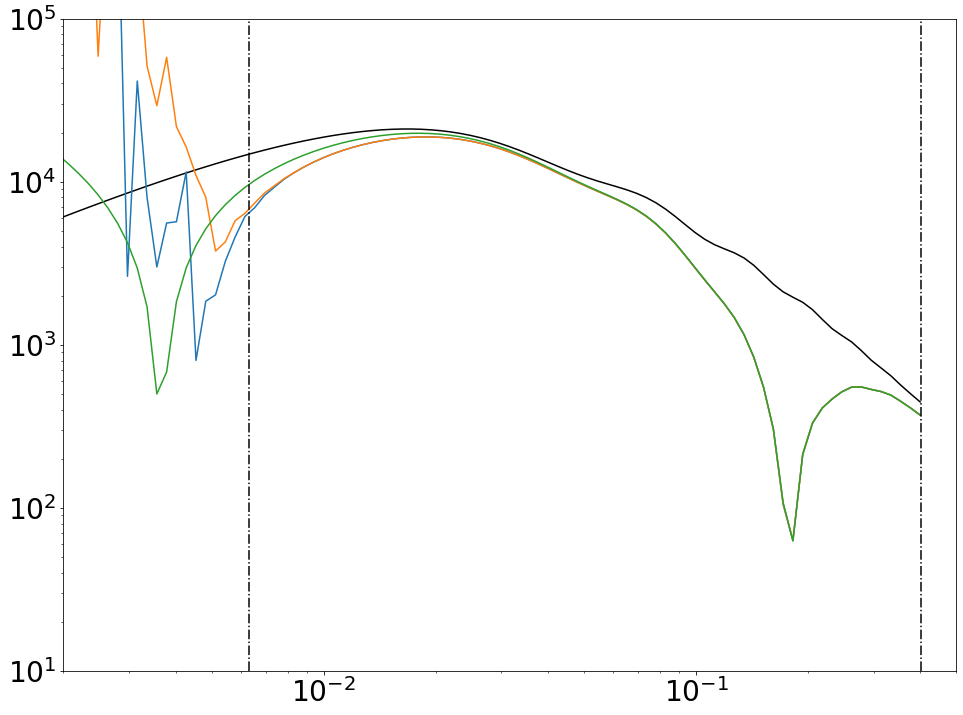

In [96]:
plt.figure(figsize=(16,12))
plt.plot(ks,Pl2_pp,'k')
#plt.plot(ks,np.abs(wa_dfog(ks,5.22,0)+wainv_dfog(ks,5.22)+inv_dfog(ks,5.22)))
#plt.plot(ks,np.abs(full_dfog_inv(ks,5.22,1)))
plt.plot(ks,np.abs(wa_dfog(ks,5.22,0)))
plt.plot(ks,np.abs(wa_dfog_fake(ks,5.22,0)))
plt.plot(ks,np.abs(pk_dfog(ks,5.22)+Pk_l2_wa))


#plt.plot(ks,np.abs(Pl2_pp+wainv_dfog(ks,5.22)))
#plt.plot(ks,np.abs(Pl2_pp+inv_dfog(ks,5.22)))





plt.axvline(x = grid_info[4], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')

plt.ylim(1e+1,1e+5)
plt.xlim(2e-3,5e-1)
plt.yscale('log')
plt.xscale('log')

NameError: name 'full_dfog' is not defined

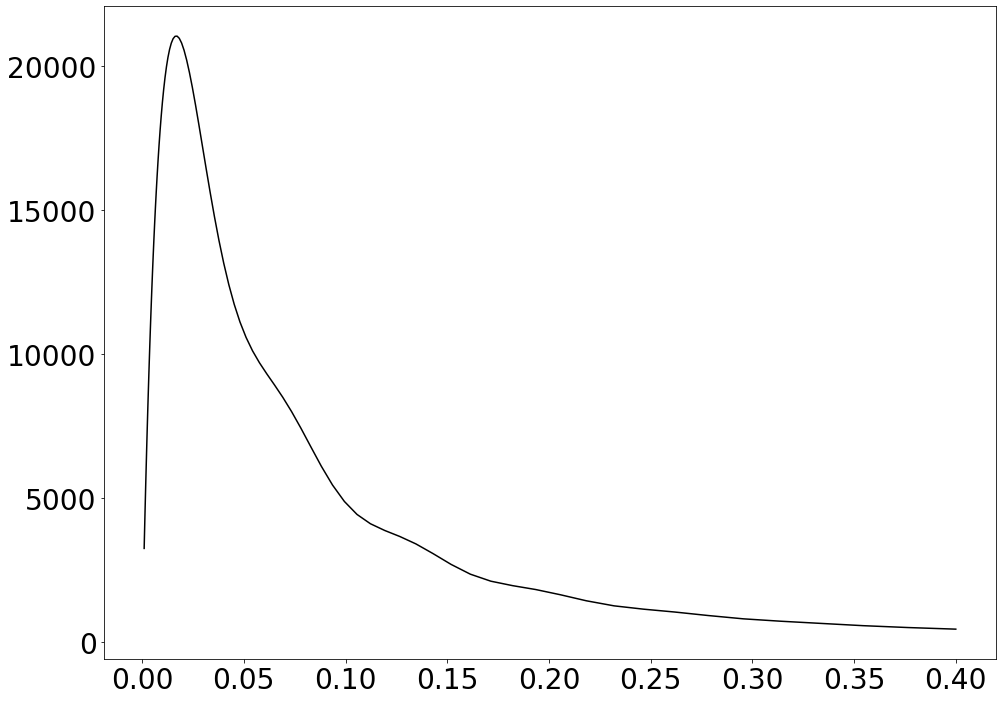

In [97]:
plt.figure(figsize=(16,12))
#plt.plot(ks,np.abs(pk_quad_dfog(ks,10)))
plt.plot(ks,Pl2_pp,'k')

plt.plot(ks,np.abs(full_dfog(ks,5.22,0)),'-.')
plt.plot(ks,np.abs(full_dfog1(ks,5.22,0)),'-.')
plt.plot(ks,np.abs(full_dfog_inv(ks,5.22,0)),'-.')
#plt.plot(ks,np.abs(full_dfog1(ks,5.22,0)))
#plt.plot(ks,np.abs(full_dfog2(ks,5.22,0)))

plt.plot(ks,np.abs(pk_quad_dfog(ks,10)))
#plt.plot(ks,np.abs(pk_quad_dfog(ks,10)+pk_quad_dfog_wa(ks,10,0)),'--',color='black')
plt.plot(ks,np.abs(pk_quad_dfog(ks,10)+Pk_l2_wa1),'--')

plt.ylim(1e+1,1e+5)
plt.xlim(2e-3,4e-1)
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(ks,pk_mono_dfog(ks,5))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)+pk_mono_dfog_wa(ks,10,0)))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)+Pk_l0_wa1))
#plt.plot(ks,np.abs(pk_quad_dfog(ks,10)+pk_quad_dfog_wa(ks,10,0)),'--')

plt.plot(ks,Pl0_pp)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
plt.plot(ks,np.abs(pk_dipo_dfog_wa(ks,10,0)))
plt.plot(ks,Pk_l1_wa)
#plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ks,np.abs(pk_mono_dfog_wa(ks,10,0)))
plt.plot(ks,np.abs(Pk_l0_wa1))

plt.xscale('log')
plt.yscale('log')
plt.grid(ls='--',lw=0.75)